In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor as rf
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data load
all_df = pd.read_csv('../data/smart_farm.csv')
all_df = all_df.iloc[:,1:]

In [3]:
for colname in all_df.columns:
    newName = colname[11:]
    print(newName)
    all_df.rename(columns={colname:newName},inplace=True)

yy
mm
dd
hh
nn
insolation
out_tmperature
out_humidity
wind_speed
wind_direction
in_tmperature
in_humidity
shield_light_h
shield_tmperature_h
shield_energy_h
shield_energy_v
exhaust_fan
ceiling
floating_fan
fan_coil_b_site
ventilation_temperature_control
heating_temperature_set_up
heat_supply


In [4]:
# 날짜 Index가 여러개 있어서 하나로 정리하고싶을 때 실행
date = all_df[['yy','mm','dd']].astype(str).apply('-'.join,axis=1)
all_df.insert(loc=0,column='date',value=date)
all_df['date'] = pd.to_datetime(all_df['date'])

In [5]:
all_df.head()

,date,yy,mm,dd,hh,nn,insolation,out_tmperature,out_humidity,wind_speed,...,shield_tmperature_h,shield_energy_h,shield_energy_v,exhaust_fan,ceiling,floating_fan,fan_coil_b_site,ventilation_temperature_control,heating_temperature_set_up,heat_supply
0,2021-11-26,2021,11,26,0,0,-2.7,5.8,67,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
1,2021-11-26,2021,11,26,0,1,-2.9,5.8,67,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
2,2021-11-26,2021,11,26,0,2,-3.0,5.7,67,0.9,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
3,2021-11-26,2021,11,26,0,3,-3.0,5.7,67,1.3,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
4,2021-11-26,2021,11,26,0,4,-2.8,5.7,67,0.9,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,1.0


In [ ]:
# 결측치 확인
all_df.isnull().sum()

date                                   0
yy                                     0
mm                                     0
dd                                     0
hh                                     0
nn                                     0
insolation                             0
out_tmperature                         0
out_humidity                           0
wind_speed                             0
wind_direction                         0
in_tmperature                        512
in_humidity                          512
shield_light_h                       512
shield_tmperature_h                  512
shield_energy_h                      512
shield_energy_v                      512
exhaust_fan                          512
ceiling                              512
floating_fan                         512
fan_coil_b_site                      512
ventilation_temperature_control      501
heating_temperature_set_up           500
heat_supply                        21075
dtype: int64

In [ ]:
all_df[all_df['in_humidity'].isnull()]

,date,yy,mm,dd,hh,nn,insolation,out_tmperature,out_humidity,wind_speed,...,shield_tmperature_h,shield_energy_h,shield_energy_v,exhaust_fan,ceiling,floating_fan,fan_coil_b_site,ventilation_temperature_control,heating_temperature_set_up,heat_supply
290,2021-11-26,2021,11,26,4,50,-3.9,2.1,79,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9
291,2021-11-26,2021,11,26,4,51,-3.7,2.1,79,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3
292,2021-11-26,2021,11,26,4,52,-3.7,2.1,78,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8
883,2021-11-26,2021,11,26,14,43,414.0,13.7,20,1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1
884,2021-11-26,2021,11,26,14,44,410.0,13.7,20,4.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127011,2022-2-25,2022,2,25,4,51,-4.0,-4.3,61,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4
129890,2022-2-27,2022,2,27,4,50,-3.5,2.2,51,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8
129891,2022-2-27,2022,2,27,4,51,-3.5,2.2,51,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8
131330,2022-2-28,2022,2,28,4,50,-3.6,-2.9,64,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4


In [9]:
all_df.dropna(axis=0,inplace=True)
all_df.isnull().sum()

date                               0
yy                                 0
mm                                 0
dd                                 0
hh                                 0
nn                                 0
insolation                         0
out_tmperature                     0
out_humidity                       0
wind_speed                         0
wind_direction                     0
in_tmperature                      0
in_humidity                        0
shield_light_h                     0
shield_tmperature_h                0
shield_energy_h                    0
shield_energy_v                    0
exhaust_fan                        0
ceiling                            0
floating_fan                       0
fan_coil_b_site                    0
ventilation_temperature_control    0
heating_temperature_set_up         0
heat_supply                        0
dtype: int64

In [11]:
all_df.to_csv("mydata/train_df.csv",index=False)

In [12]:
# 스마트팜 내부제어 요소 리스트
List_Control = ['shield_light_h','shield_tmperature_h','shield_energy_h','shield_energy_v','exhaust_fan','ceiling','floating_fan','fan_coil_b_site']

<AxesSubplot:xlabel='ventilation_temperature_control', ylabel='heat_supply'>

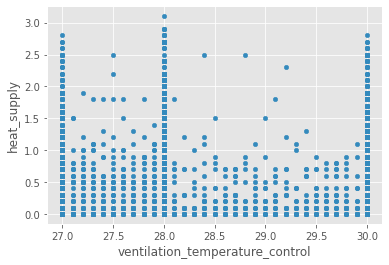

In [14]:
all_df.plot.scatter(x='ventilation_temperature_control', y='heat_supply')

<AxesSubplot:xlabel='heating_temperature_set_up', ylabel='heat_supply'>

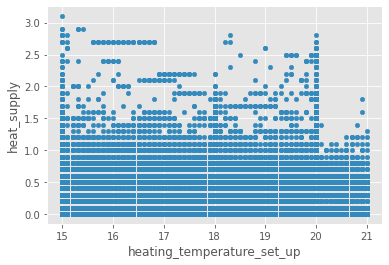

In [15]:
all_df.plot.scatter(x='heating_temperature_set_up', y='heat_supply')

In [16]:
all_df_corr = all_df.drop(['date'],axis=1)
all_df_corr = all_df_corr.corr()

<AxesSubplot:>

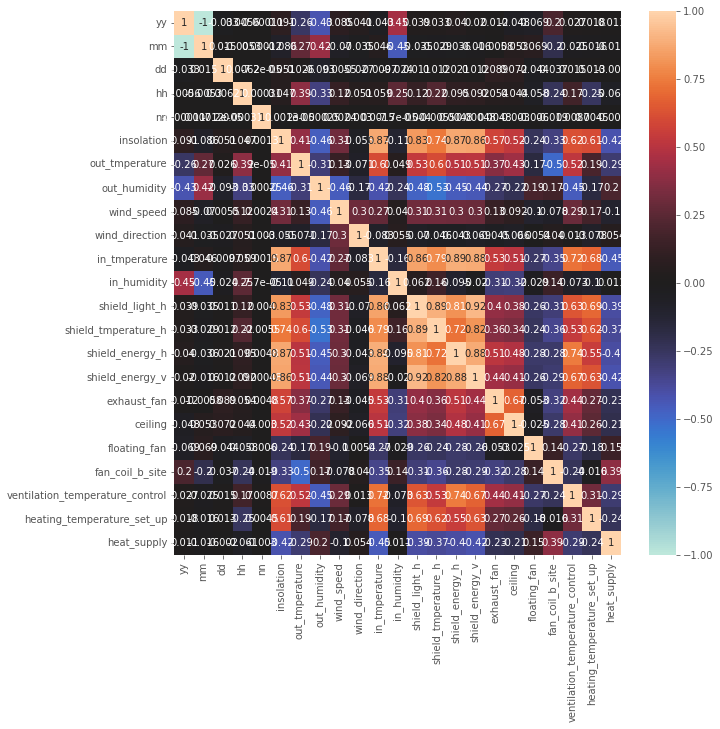

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(all_df_corr,vmax=1, vmin=-1, center=0, annot=True)

In [24]:
all_df_corr['heat_supply'].abs().sort_values(ascending=False)

heat_supply                        1.000000
in_tmperature                      0.447005
insolation                         0.418622
shield_energy_v                    0.417054
shield_energy_h                    0.397606
shield_light_h                     0.394565
fan_coil_b_site                    0.387982
shield_tmperature_h                0.371107
out_tmperature                     0.294948
ventilation_temperature_control    0.291972
heating_temperature_set_up         0.241353
exhaust_fan                        0.225705
ceiling                            0.206632
out_humidity                       0.197376
floating_fan                       0.148125
wind_speed                         0.103883
hh                                 0.061447
wind_direction                     0.053810
mm                                 0.015503
yy                                 0.011437
in_humidity                        0.010937
nn                                 0.003039
dd                              